In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
from __future__ import print_function
from numpy import *
from scipy import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import reload
import matplotlib.patches as patches

import netCDF4 as nc
import numpy as np
import scipy as sp

import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

# matplotlib.use('Agg')
# plt.style.use('seaborn-whitegrid')
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs

from scipy import optimize
import arrow
import gsw
import pandas as pd
%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## METHOD SUMMARY: Essentially, we ask: how old is this water? We get a proxy for how old the water is via how dense it is. Then we ask: What atmospheric CO2 did it see when it was last at the surface? How different is that CO2 from preindustrial CO2? This is the CO2 anthropogenic intrusion. So, surface water will have a big intrusion, deep water won't. We then subtract the intrusion (in pco2) from the mocsy-calculated pco2 of the present-day boundary conditions to get preindustrial pco2. THEN we use the same TA and all other conditions, with this different pco2, to calculate the preindustrial DIC.

## Part 1: Use  isopycnal vs ventilation age relationship to get age of watermass estimate, then use co2 levels at that age to get identity of co2 intrusion



    1) plot age of water as fxn of isopycnal - use scipy-optimize...
    2) plot intrusion of pco2 as fxn of age...what is the 'correct' reference here?
    
problem - the age of water as a function of isopycnal gets very exponential very quickly- an isopycnal of 25.7 has an age of ~320 years. 


##### atmospheric CO2 - used co2levels.org data sources, 
###### smoothed yearly product (ice core 1832-1959, maunaloa 1959-pres)

    1832- 1958: https://cdiac.ess-dive.lbl.gov/ftp/trends/co2/lawdome.combined.dat
    1959 - pres: https://www.co2levels.org/#sources




### PPM CO2 from 1832-2018, using above sources, and code to look up atmco2 for a given year from 1832-2018

In [4]:
co2_rec = pd.read_csv('lawdome_maunaloa.csv') 


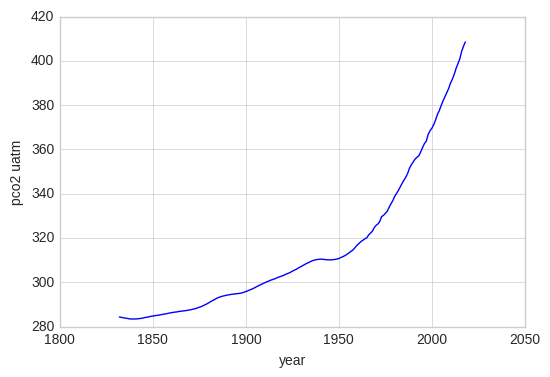

In [5]:
plt.plot(co2_rec['YEAR'],co2_rec['PPMCO2'])
plt.ylabel('pco2 uatm')
plt.xlabel('year')

In [6]:
co2_rec = pd.read_csv('lawdome_maunaloa.csv') 
def co2_from_year(year):
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    
    whole_year = int(year)
    
    if whole_year >= 2018:
        whole_year = 2018     
        #print('year > 2018, using value for 2018')
        
    if whole_year <= 1832:
        whole_year = 1832
        #print('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2

In [7]:
#test
ty = 1000
tco2 = co2_from_year(ty)
print('year: '+str(ty) +', pco2: '+str(tco2))
ty = 1900
tco2 = co2_from_year(ty)
print('year: '+str(ty) +', pco2: '+str(tco2))
ty = 2004
tco2 = co2_from_year(ty)
print('year: '+str(ty) +', pco2: '+str(tco2))

year: 1000, pco2: 284.3
year: 1900, pco2: 295.8
year: 2004, pco2: 377.52


## from Tetjana's plot, define pycnals and ventilation age, use scipy curve_fit to make a fxn of ventilation time/year last at surface vs pycnal, use above code to find atm co2 when pycnal was last at surface

In [8]:

pycnal = np.array([24.4, 25.15, 25.4, 25.6])
pycnal_age = np.array([0,1,10,100])

def test_func(x, a, b, c):
    return a * np.exp(-b * (25.15-x)) + c

params, params_covariance = optimize.curve_fit(test_func, pycnal, pycnal_age,
                                               p0=[1, -0.05, -25.15])
params0 = params[0]
params1 = params[1]
params2 = params[2]
print(params0)
print(params1)
print(params2)

pycnal_forfunc =np.arange(24.4,27,0.05)
pycnal_age_fromfunc = params0 *np.exp(-params1*(25.15-pycnal_forfunc))+params2
pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-pycnal_forfunc))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)

for i in range(0,len(pycnal_original_co2)):
    ty = pycnal_last_at_surface[i]
    tco2 = co2_from_year(ty)
    pycnal_original_co2[i] = tco2
    
    
pycnal_intrusion = 409 - pycnal_original_co2


0.5406570488955575
11.595484591464743
0.2153367515219747


## ventilation age as a fxn of isopycnal, station P04, km 220

## we see that 25.4-25.7 is the critical interval where age matters.

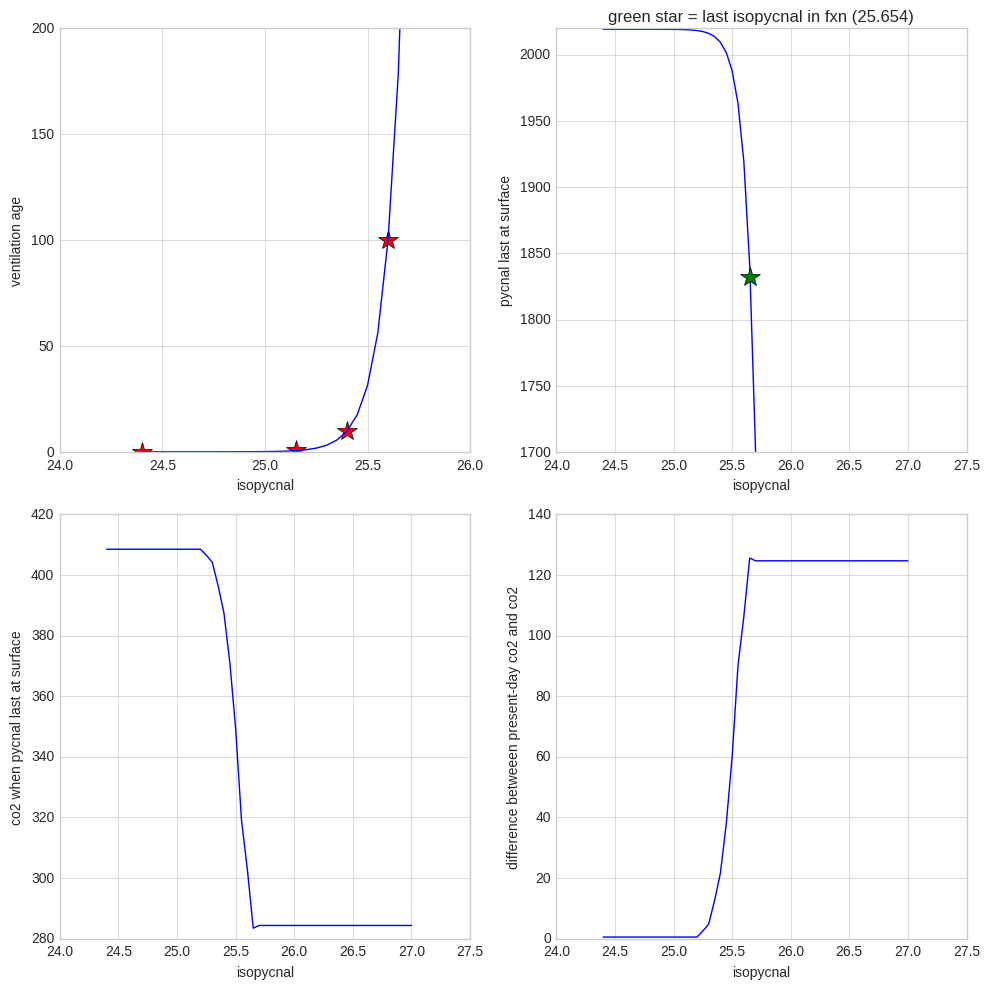

In [9]:
fig = plt.figure(figsize=(10,10))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(2,2,i)
        ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_age_fromfunc)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('ventilation age')
        ax.set_xlim([24.0,26.0])
        ax.set_ylim([0,200])
        

    if i == 2:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_last_at_surface)
        ax.plot(25.654,1832.1497986658724,'g*', markersize = 15)
        ax.set_ylim([1700,2020])
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('pycnal last at surface')
        ax.set_title('green star = last isopycnal in fxn (25.654)')

    if i == 3:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_original_co2)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('co2 when pycnal last at surface')


    if i == 4:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_intrusion)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('difference betweeen present-day co2 and co2')

   
        
plt.tight_layout()

In [10]:
pycnal_forfunc2 = 24.4
pycnal_age_fromfunc = params[0] *np.exp(-params[1]*(25.15-pycnal_forfunc2))+params[2]
pycnal_last_at_surface = 2019 - pycnal_age_fromfunc
print('minimum pycnal for function: ', pycnal_forfunc2)
print('last at surface:', pycnal_last_at_surface)
pycnal_forfunc2 = 25.654
pycnal_age_fromfunc = params[0] *np.exp(-params[1]*(25.15-pycnal_forfunc2))+params[2]
pycnal_last_at_surface = 2019 - pycnal_age_fromfunc
print('Max pycnal for function: ', pycnal_forfunc2)
print('last at surface:', pycnal_last_at_surface)

minimum pycnal for function:  24.4
last at surface: 2018.7845728771551
Max pycnal for function:  25.654
last at surface: 1832.1497986658724


In [11]:
test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m06d01.nc')
zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
potdens = gsw.sigma0(sal,temp)
potdens_mask = np.copy(potdens)
potdens_mask[potdens>24.4] = 1
potdens_mask[potdens<=24.4] = -1

DIC = test_LO['DIC'][0,:,0,:]
TA = test_LO['TA'][0,:,0,:]

depth_this = np.zeros_like(TA)

for i in range(0,950):
    depth_this[:,i] = zlevels

In [18]:
densrange = np.arange(24.4,27,0.01)

amp = -1.39e+02  
wid = 1.50e-02  
ctr = 2.66e+01
ctr_bef = 2.658e+01
ctr_aft = 2.662e+01
pff = 25.655
paf = params0 *np.exp(-params1*(25.15-pff))+params2

pycnal_last_at_surface = np.zeros_like(densrange)
for i in range(0,len(densrange)):
    for j in range(0,1):
        t_potdens = densrange[i]
        if (t_potdens <= 25.655):
            pycnal_last_at_surface[i] = 2019 - params0 *np.exp(-params1*(25.15-t_potdens))+params2
        if ((t_potdens> 25.655) & (t_potdens < 26.58)):
            pycnal_last_at_surface[i] =  2019 - (paf + amp * np.exp( -((t_potdens - ctr_bef)/wid)**2))
        if((t_potdens> ctr_bef) & (t_potdens < ctr_aft)):
            pycnal_last_at_surface[i] = 2019 - (paf + amp)
        if ((t_potdens> ctr_aft)):
            pycnal_last_at_surface[i] = 2019 - (paf + amp * np.exp( -((t_potdens - ctr_aft)/wid)**2)) 

amp = -1.39e+02  
wid = 4.50e-02  
ctr = 2.66e+01
ctr_bef = 2.658e+01
ctr_aft = 2.662e+01
pff = 25.655
paf = params0 *np.exp(-params1*(25.15-pff))+params2

pycnal_last_at_surface2 = np.zeros_like(densrange)
for i in range(0,len(densrange)):
    for j in range(0,1):
        t_potdens = densrange[i]
        if (t_potdens <= 25.655):
            pycnal_last_at_surface2[i] = 2019 - params0 *np.exp(-params1*(25.15-t_potdens))+params2
        if ((t_potdens> 25.655) & (t_potdens < 26.58)):
            pycnal_last_at_surface2[i] =  2019 - (paf + amp * np.exp( -((t_potdens - ctr_bef)/wid)**2))
        if((t_potdens> ctr_bef) & (t_potdens < ctr_aft)):
            pycnal_last_at_surface2[i] = 2019 - (paf + amp)
        if ((t_potdens> ctr_aft)):
            pycnal_last_at_surface2[i] = 2019 - (paf + amp * np.exp( -((t_potdens - ctr_aft)/wid)**2)) 


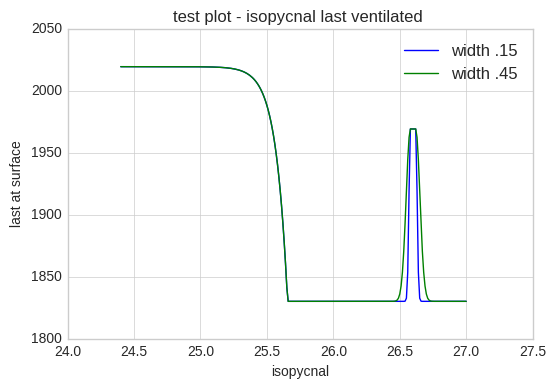

In [20]:

plt.title('test plot - isopycnal last ventilated ')
plt.plot(densrange,pycnal_last_at_surface, label ='width .15')
plt.plot(densrange,pycnal_last_at_surface2, label ='width .45')
plt.ylabel('last at surface')
plt.xlabel('isopycnal')
plt.legend()